## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from datetime import datetime
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Layer, Input, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import shap

In [2]:
# Hide warnings!
import warnings
warnings.filterwarnings("ignore")

In [3]:
# For reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Forecasting NO2 based on PM2.5 pre-trained model

In [4]:
# Importing dataset from station Aotizhongxin
df = pd.read_csv("datasets/cleaned_df.csv")

In [5]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,6,1.2


In [6]:
# Defining features and target
features_NO2 = df.drop(columns = ['PM10','SO2','PM2.5','CO','O3'])

In [7]:
features_NO2

,NO2,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,7.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,7.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,10.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,11.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,12.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...
35059,35.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,45.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,66.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,87.0,10.5,1014.4,-12.9,0.0,6,1.2


In [8]:
features_NO2.isna().sum()

NO2     0
TEMP    0
PRES    0
DEWP    0
RAIN    0
wd      0
WSPM    0
dtype: int64

In [9]:
# Changing the position of the 'wd' column

# Column to move
col_to_move = 'wd'

# Get a list of all columns
cols = list(features_NO2.columns)

# Remove the column from the list
cols.remove(col_to_move)

# Append the column to the end of the list
cols.append(col_to_move)

# Reindex the DataFrame
features_NO2 = features_NO2[cols]

In [10]:
features_NO2

,NO2,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,7.0,-0.7,1023.0,-18.8,0.0,4.4,6
1,7.0,-1.1,1023.2,-18.2,0.0,4.7,3
2,10.0,-1.1,1023.5,-18.2,0.0,5.6,6
3,11.0,-1.4,1024.5,-19.4,0.0,3.1,7
4,12.0,-2.0,1025.2,-19.5,0.0,2.0,3
...,...,...,...,...,...,...,...
35059,35.0,12.5,1013.5,-16.2,0.0,2.4,7
35060,45.0,11.6,1013.6,-15.1,0.0,0.9,14
35061,66.0,10.8,1014.2,-13.3,0.0,1.1,7
35062,87.0,10.5,1014.4,-12.9,0.0,1.2,6


In [11]:
# Create sequences
SEQ_LENGTH = 1
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
fine_tuning_size = [0.1, 0.2, 0.3, 0.4, 0.5]

In [13]:
best_params_ann = {'num_hidden_layers': 1, 'num_units': 8, 'dropout_rate': 0.14382634727054072, 
                  'learning_rate': 0.001540087615233534, 'regularization': None, 
                  'regularization_strength': 0}

In [14]:
def train_test_split_standardize(train_size):
    
    len_train = int(train_size * len(features_NO2))
    
    train_df = features_NO2.iloc[:len_train, :-1]
    test_df = features_NO2.iloc[len_train:, :-1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    train_df['wd'] = features_NO2.iloc[:len_train, -1]
    test_df['wd'] = features_NO2.iloc[len_train:, -1]
    
    X_train, y_train = create_sequences(np.array(train_df), SEQ_LENGTH)
    X_test, y_test = create_sequences(np.array(test_df), SEQ_LENGTH)
    
    return X_train, y_train, X_test, y_test

In [15]:
X_train_NO2, y_train_NO2, X_test_NO2, y_test_NO2 = train_test_split_standardize(0.3)

In [16]:
print("Train shape: ", X_train_NO2.shape)
print("Test shape: ", X_test_NO2.shape)

Train shape:  (10518, 1, 7)
Test shape:  (24544, 1, 7)


In [17]:
X_train_NO2

array([[[-1.65486771e+00, -1.30927509e+00,  1.30236737e+00, ...,
         -6.20225909e-02,  2.44235361e+00,  6.00000000e+00]],

       [[-1.65486771e+00, -1.34717207e+00,  1.32307167e+00, ...,
         -6.20225909e-02,  2.70391712e+00,  3.00000000e+00]],

       [[-1.56755455e+00, -1.34717207e+00,  1.35412812e+00, ...,
         -6.20225909e-02,  3.48860768e+00,  6.00000000e+00]],

       ...,

       [[ 2.66021864e-01, -1.13035246e-02, -1.61693932e+00, ...,
         -6.20225909e-02, -8.70784300e-01,  1.00000000e+00]],

       [[ 2.36917476e-01,  1.71192105e-02, -1.59623501e+00, ...,
         -6.20225909e-02, -7.83596461e-01,  1.00000000e+00]],

       [[ 5.57065739e-01,  1.21335906e-01, -1.52376996e+00, ...,
         -6.20225909e-02,  1.09409591e-03,  4.00000000e+00]]])

In [53]:
mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

for s in fine_tuning_size:
    
    # Training set
    
    X_train_NO2, y_train_NO2, X_test_NO2, y_test_NO2 = train_test_split_standardize(s)
        
    # Loading the saved model
    pre_trained_model = tf.keras.models.load_model('pre_trained_models/LSTM_model.h5')
    pre_trained_model.compile(optimizer=Adam(learning_rate = best_params_ann['learning_rate']/10), loss='mse', metrics=['mae'])
    pre_trained_model.fit(X_train_NO2, y_train_NO2, epochs = 50, batch_size=32, shuffle=False)
    
    # Make predictions on the test data
    y_pred_ft = pre_trained_model.predict(X_test_NO2)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_NO2, y_pred_ft)
    mae = mean_absolute_error(y_test_NO2, y_pred_ft)
    r2 = r2_score(y_test_NO2, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_NO2, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_NO2, y_pred_ft))
    
    # Append to list scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    

Epoch 1/50
110/110 [==============================] - 3s 4ms/step - loss: 0.2140 - mae: 0.3099
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2079 - mae: 0.3038
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2085 - mae: 0.3078
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2091 - mae: 0.3056
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2023 - mae: 0.3011
Epoch 6/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2086 - mae: 0.3049
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2030 - mae: 0.3042
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2128 - mae: 0.3079
Epoch 9/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2130 - mae: 0.3100
Epoch 10/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2132 - mae: 0.3077
Epoch 11/50
110/110 [============================

Epoch 36/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1889 - mae: 0.2952
Epoch 37/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1843 - mae: 0.2942
Epoch 38/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1784 - mae: 0.2878
Epoch 39/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1808 - mae: 0.2905
Epoch 40/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1857 - mae: 0.2940
Epoch 41/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1822 - mae: 0.2900
Epoch 42/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1814 - mae: 0.2889
Epoch 43/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1796 - mae: 0.2901
Epoch 44/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1897 - mae: 0.2953
Epoch 45/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1792 - mae: 0.2908
Epoch 46/50
220/220 [===================

439/439 [==============================] - 1s 3ms/step - loss: 0.1786 - mae: 0.2932
Epoch 21/50
439/439 [==============================] - 2s 4ms/step - loss: 0.1814 - mae: 0.2948
Epoch 22/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1767 - mae: 0.2937
Epoch 23/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1760 - mae: 0.2922
Epoch 24/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1796 - mae: 0.2950
Epoch 25/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1770 - mae: 0.2934
Epoch 26/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1797 - mae: 0.2944
Epoch 27/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1768 - mae: 0.2926
Epoch 28/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1766 - mae: 0.2938
Epoch 29/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1748 - mae: 0.2915
Epoch 30/50
439/439 [==============================]

In [54]:
mae_scores 

[0.25847039645104447,
 0.2562028692713812,
 0.24309212353662654,
 0.2438011315064785,
 0.22679345686273605]

In [55]:
mse_scores

[0.13934241029315172,
 0.13954066381605318,
 0.12746423001066,
 0.1348602226321625,
 0.11493758234886761]

In [56]:
rmse_scores

[0.37328596316115575,
 0.3735514205782829,
 0.3570213299099369,
 0.3672331992510515,
 0.33902445685948324]

In [57]:
mape_scores 

[0.8434002375185642,
 0.8939601383821855,
 1.1100210213503885,
 1.009468007137239,
 0.8065090751477827]

In [58]:
r2_scores

[0.8926709991689555,
 0.8956902975649105,
 0.895341390268248,
 0.9034991648029008,
 0.8965296340181512]

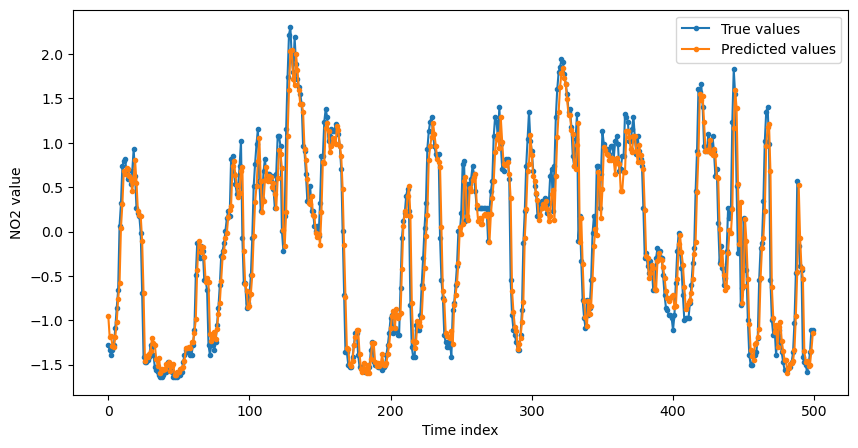

In [24]:
# Forecasting test set values

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(np.array(y_test_NO2)[:500], label = 'True values', marker = '.')
plt.plot(y_pred_ft[:500], label = 'Predicted values', marker = '.')

plt.legend()

plt.xlabel("Time index")
plt.ylabel("NO2 value")

plt.savefig("actual_vs_forecasts_plot_NO2.pdf")
plt.show()

## Forecasting NO2 without Transfer Learning

In [25]:
def build_ann_model(input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(8, activation='relu'))
              
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [26]:
mse_scores_2 = []
mae_scores_2 = []
rmse_scores_2 = []
mape_scores_2 = []
r2_scores_2 = []

for s in fine_tuning_size:
    # Training set
    X_train_NO2, y_train_NO2, X_test_NO2, y_test_NO2 = train_test_split_standardize(s)
    
    # Loading the saved model
    model = build_ann_model(X_train_NO2.shape[1:])
    model.fit(X_train_NO2, y_train_NO2, epochs = 50, shuffle = False, batch_size = 32)
    
    # Make predictions on the test data
    y_pred_ft = model.predict(X_test_NO2)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_NO2, y_pred_ft)
    mae = mean_absolute_error(y_test_NO2, y_pred_ft)
    r2 = r2_score(y_test_NO2, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_NO2, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_NO2, y_pred_ft))
    
    # Append to list scores
    mse_scores_2.append(mse)
    mae_scores_2.append(mae)
    r2_scores_2.append(r2)
    rmse_scores_2.append(rmse)
    mape_scores_2.append(mape)
    
    

Epoch 1/50
110/110 [==============================] - 1s 2ms/step - loss: 7.9800 - mae: 2.1632
Epoch 2/50
110/110 [==============================] - 0s 2ms/step - loss: 2.6060 - mae: 1.1841
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 1.9353 - mae: 1.0263
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 1.5835 - mae: 0.9365
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 1.3257 - mae: 0.8637
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 1.1126 - mae: 0.7994
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 1.0392 - mae: 0.7711
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.9380 - mae: 0.7376
Epoch 9/50
110/110 [==============================] - 0s 3ms/step - loss: 0.7980 - mae: 0.6828
Epoch 10/50
110/110 [==============================] - 0s 3ms/step - loss: 0.7295 - mae: 0.6523
Epoch 11/50
110/110 [============================

Epoch 36/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1889 - mae: 0.3004
Epoch 37/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1876 - mae: 0.2993
Epoch 38/50
220/220 [==============================] - 1s 2ms/step - loss: 0.1796 - mae: 0.2966
Epoch 39/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1827 - mae: 0.2989
Epoch 40/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1842 - mae: 0.3004
Epoch 41/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1827 - mae: 0.2993
Epoch 42/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1851 - mae: 0.2994
Epoch 43/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1899 - mae: 0.3018
Epoch 44/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1809 - mae: 0.2952
Epoch 45/50
220/220 [==============================] - 1s 3ms/step - loss: 0.1787 - mae: 0.2962
Epoch 46/50
220/220 [===================

439/439 [==============================] - 1s 2ms/step - loss: 0.1886 - mae: 0.3047
Epoch 21/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1874 - mae: 0.3058
Epoch 22/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1833 - mae: 0.3026
Epoch 23/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1796 - mae: 0.3008
Epoch 24/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1862 - mae: 0.3057
Epoch 25/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1856 - mae: 0.3035
Epoch 26/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1862 - mae: 0.3045
Epoch 27/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1838 - mae: 0.3022
Epoch 28/50
439/439 [==============================] - 1s 3ms/step - loss: 0.1818 - mae: 0.3029
Epoch 29/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1804 - mae: 0.3008
Epoch 30/50
439/439 [==============================]

In [27]:
mae_scores_2

[0.33663722991120476,
 0.27918657858436624,
 0.24196581895144,
 0.26535662002441146,
 0.22784615611839426]

In [28]:
mse_scores_2

[0.21002642707093075,
 0.15493397558638541,
 0.1325552523925679,
 0.15056994882628363,
 0.12070583167552942]

In [29]:
rmse_scores_2

[0.45828640288680916,
 0.39361653368016114,
 0.3640813815516634,
 0.3880334377682981,
 0.34742744807445686]

In [30]:
r2_scores_2

[0.8382263768926272,
 0.8841834598708419,
 0.8911612424372907,
 0.8922578835054095,
 0.891336877595864]